In [1]:
# general imports
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch
import torchvision.transforms as transforms
import random

In [2]:
# filter python warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# prepare CIFAR data
import torchvision.datasets as datasets

scale = np.mean(np.arange(0, 256))
normalize = lambda x: (x - scale) / scale

# train data
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar_train_images = normalize(cifar_trainset.train_data)
cifar_train_labels = np.array(cifar_trainset.train_labels)

# get only train images and labels for two classes: 3 (cat) and 5 (dog)
cifar_train_images_3_5 = np.concatenate([cifar_train_images[cifar_train_labels==3], cifar_train_images[cifar_train_labels==5]])
cifar_train_labels_3_5 = np.concatenate([np.repeat(0, np.sum(cifar_train_labels==3)), np.repeat(1, np.sum(cifar_train_labels==5))])

# test data
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
cifar_test_images = normalize(cifar_testset.test_data)
cifar_test_labels = np.array(cifar_testset.test_labels)

# get only test images and labels for two classes: 3 (cat) and 5 (dog)
cifar_test_images_3_5 = np.concatenate([cifar_test_images[cifar_test_labels==3], cifar_test_images[cifar_test_labels==5]])
cifar_test_labels_3_5 = np.concatenate([np.repeat(0, np.sum(cifar_test_labels==3)), np.repeat(1, np.sum(cifar_test_labels==5))])
# print(np.min(cifar_train_images_3_5))
# print(np.max(cifar_train_images_3_5))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# All of CIFAR 10
print(cifar_train_images.shape)
print(cifar_test_images.shape)
print(np.unique(cifar_test_labels))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
[0 1 2 3 4 5 6 7 8 9]


In [5]:
# Cats vs Dogs (CIFAR)
print(cifar_train_images_3_5.shape)
print(cifar_test_images_3_5.shape)
print(np.unique(cifar_test_labels_3_5))

(10000, 32, 32, 3)
(2000, 32, 32, 3)
[0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0


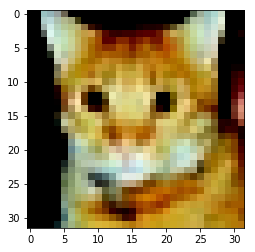

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 1


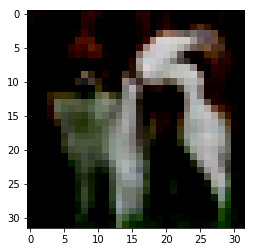

In [6]:
# visualize data and labels
import matplotlib.pyplot as plt
%matplotlib inline

# 3 (label 0)
index = 2500
print("Label:", cifar_train_labels_3_5[index])
plt.imshow(cifar_train_images_3_5[index])
plt.show()

# 5 (label 1)
index = 7500
print("Label:", cifar_train_labels_3_5[index])
plt.imshow(cifar_train_images_3_5[index])
plt.show()

In [41]:
print("Naive Random Forest (by flattening the entire image)")
# Train
clf = RandomForestClassifier()
clf.fit(cifar_train_images_3_5.reshape(-1, 32*32*3), cifar_train_labels_3_5)
# Test
cifar_test_preds_3_5 = clf.predict(cifar_test_images_3_5.reshape(-1, 32*32*3))
print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds_3_5)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds_3_5)))

Naive Random Forest (by flattening the entire image)
Test Accuracy: 0.602
Validation Confusion Matrix: 
[[694 306]
 [490 510]]


In [45]:
# The Deep Convolution Random Forest class (for binary classification)
class ConvRF(object):
    def __init__(self, kernel_size=5, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_forest = None

    def _convolve_chop(self, images, labels=None, flatten=False):

        batch_size, in_dim, _, num_channels = images.shape

        out_dim = int((in_dim - self.kernel_size) / self.stride) + 1  # calculate output dimensions

        # create matrix to hold the chopped images
        out_images = np.zeros((batch_size, out_dim, out_dim,
                               self.kernel_size, self.kernel_size, num_channels))
        out_labels = None

        curr_y = out_y = 0
        # move kernel vertically across the image
        while curr_y + self.kernel_size <= in_dim:
            curr_x = out_x = 0
            # move kernel horizontally across the image
            while curr_x + self.kernel_size <= in_dim:
                # chop images
                out_images[:, out_x, out_y] = images[:, curr_x:curr_x +
                                                     self.kernel_size, curr_y:curr_y+self.kernel_size, :]
                curr_x += self.stride
                out_x += 1
            curr_y += self.stride
            out_y += 1

        if flatten:
            out_images = out_images.reshape(batch_size, out_dim, out_dim, -1)

        if labels is not None:
            out_labels = np.zeros((batch_size, out_dim, out_dim))
            out_labels[:, ] = labels.reshape(-1, 1, 1)

        return out_images, out_labels

    def convolve_fit(self, images, labels):
        num_channels = images.shape[-1]
        sub_images, sub_labels = self._convolve_chop(images, labels=labels, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        
#         all_sub_images = sub_images.reshape(batch_size*out_dim*out_dim, -1)
#         all_sub_labels = sub_labels.reshape(batch_size*out_dim*out_dim, -1)
        
        # print(all_sub_images.shape)

        # fit all sub images to a forest
        self.kernel_forest = RandomForestClassifier(n_estimators=500, n_jobs=-1, warm_start=True)

        convolved_image = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                self.kernel_forest.fit(sub_images[:, i, j], sub_labels[:, i, j])
                convolved_image[:, i, j] = self.kernel_forest.predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return convolved_image

    def convolve_predict(self, images):
        if not self.kernel_forest:
            raise Exception("Should fit training data before predicting")

        num_channels = images.shape[-1]
        sub_images, _ = self._convolve_chop(images, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        
        kernel_predictions = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                kernel_predictions[:, i, j] = self.kernel_forest.predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return kernel_predictions

In [52]:
# The Deep Convolution Random Forest class (for binary classification)
class ConvRFOld(object):
    def __init__(self, kernel_size=5, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_forests = None

    def _convolve_chop(self, images, labels=None, flatten=False):

        batch_size, in_dim, _, num_channels = images.shape

        out_dim = int((in_dim - self.kernel_size) / self.stride) + 1  # calculate output dimensions

        # create matrix to hold the chopped images
        out_images = np.zeros((batch_size, out_dim, out_dim,
                               self.kernel_size, self.kernel_size, num_channels))
        out_labels = None

        curr_y = out_y = 0
        # move kernel vertically across the image
        while curr_y + self.kernel_size <= in_dim:
            curr_x = out_x = 0
            # move kernel horizontally across the image
            while curr_x + self.kernel_size <= in_dim:
                # chop images
                out_images[:, out_x, out_y] = images[:, curr_x:curr_x +
                                                     self.kernel_size, curr_y:curr_y+self.kernel_size, :]
                curr_x += self.stride
                out_x += 1
            curr_y += self.stride
            out_y += 1

        if flatten:
            out_images = out_images.reshape(batch_size, out_dim, out_dim, -1)

        if labels is not None:
            out_labels = np.zeros((batch_size, out_dim, out_dim))
            out_labels[:, ] = labels.reshape(-1, 1, 1)

        return out_images, out_labels

    def convolve_fit(self, images, labels):
        num_channels = images.shape[-1]
        sub_images, sub_labels = self._convolve_chop(images, labels=labels, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        self.kernel_forests = np.zeros((out_dim, out_dim), dtype=np.int).tolist()
        convolved_image = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                self.kernel_forests[i][j] = RandomForestClassifier(n_estimators=32)
                self.kernel_forests[i][j].fit(sub_images[:, i, j], sub_labels[:, i, j])
                convolved_image[:, i, j] = self.kernel_forests[i][j].predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return convolved_image

    def convolve_predict(self, images):
        if not self.kernel_forests:
            raise Exception("Should fit training data before predicting")

        num_channels = images.shape[-1]
        sub_images, _ = self._convolve_chop(images, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        
        kernel_predictions = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                kernel_predictions[:, i, j] = self.kernel_forests[i][j].predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return kernel_predictions

In [46]:
###### print("DeepConvRF: One ConvRF")
print("Kernel Size: (10,10); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(cifar_train_images_3_5, cifar_train_labels_3_5)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier(n_estimators=100, n_jobs=-1)
conv1_full_RF.fit(conv1_map.reshape(len(cifar_train_images_3_5), -1), cifar_train_labels_3_5)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(cifar_test_images_3_5)
cifar_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(cifar_test_images_3_5), -1))

print("Test Accuracy: " + str(accuracy_score(cifar_test_labels_3_5, cifar_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(cifar_test_labels_3_5, cifar_test_preds)))

Kernel Size: (10,10); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF map output shape: (12, 12)
Test Accuracy: 0.603
Validation Confusion Matrix: 
[[582 418]
 [376 624]]


In [53]:
def run_naive_rf(train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=8):
    num_train_samples_class_1 = int(np.sum(train_labels==class1) * fraction_of_train_samples)
    num_train_samples_class_2 = int(np.sum(train_labels==class2) * fraction_of_train_samples)
    
    # get only train images and labels for class 1 and class 2
    train_images = np.concatenate([train_images[train_labels==class1][:num_train_samples_class_1], train_images[train_labels==class2][:num_train_samples_class_2]])
    train_labels = np.concatenate([np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

    # get only test images and labels for class 1 and class 2
    test_images = np.concatenate([test_images[test_labels==class1], test_images[test_labels==class2]])
    test_labels = np.concatenate([np.repeat(0, np.sum(test_labels==class1)), np.repeat(1, np.sum(test_labels==class2))])

    # Train
    clf = RandomForestClassifier()
    clf.fit(train_images.reshape(-1, 32*32*3), train_labels)
    # Test
    test_preds = clf.predict(test_images.reshape(-1, 32*32*3))
    return accuracy_score(test_labels, test_preds)

In [54]:
def run_one_layer_deep_conv_rf(train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=8):
    num_train_samples_class_1 = int(np.sum(train_labels==class1) * fraction_of_train_samples)
    num_train_samples_class_2 = int(np.sum(train_labels==class2) * fraction_of_train_samples)
    
    # get only train images and labels for class 1 and class 2
    train_images = np.concatenate([train_images[train_labels==class1][:num_train_samples_class_1], train_images[train_labels==class2][:num_train_samples_class_2]])
    train_labels = np.concatenate([np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

    # get only test images and labels for class 1 and class 2
    test_images = np.concatenate([test_images[test_labels==class1], test_images[test_labels==class2]])
    test_labels = np.concatenate([np.repeat(0, np.sum(test_labels==class1)), np.repeat(1, np.sum(test_labels==class2))])
    
    ## Train
    # ConvRF (layer 1)
    conv1 = ConvRF(kernel_size=10, stride=2)
    conv1_map = conv1.convolve_fit(train_images, train_labels)

    # Full RF
    conv1_full_RF = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    conv1_full_RF.fit(conv1_map.reshape(len(train_images), -1), train_labels)

    ## Test (after ConvRF 1 and Full RF)
    conv1_map_test = conv1.convolve_predict(test_images)
    mnist_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(test_images), -1))

    return accuracy_score(test_labels, mnist_test_preds)

In [55]:
def run_one_layer_deep_conv_rf_old(train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=8):
    num_train_samples_class_1 = int(np.sum(train_labels==class1) * fraction_of_train_samples)
    num_train_samples_class_2 = int(np.sum(train_labels==class2) * fraction_of_train_samples)
    
    # get only train images and labels for class 1 and class 2
    train_images = np.concatenate([train_images[train_labels==class1][:num_train_samples_class_1], train_images[train_labels==class2][:num_train_samples_class_2]])
    train_labels = np.concatenate([np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

    # get only test images and labels for class 1 and class 2
    test_images = np.concatenate([test_images[test_labels==class1], test_images[test_labels==class2]])
    test_labels = np.concatenate([np.repeat(0, np.sum(test_labels==class1)), np.repeat(1, np.sum(test_labels==class2))])
    
    ## Train
    # ConvRF (layer 1)
    conv1 = ConvRFOld(kernel_size=10, stride=2)
    conv1_map = conv1.convolve_fit(train_images, train_labels)

    # Full RF
    conv1_full_RF = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    conv1_full_RF.fit(conv1_map.reshape(len(train_images), -1), train_labels)

    ## Test (after ConvRF 1 and Full RF)
    conv1_map_test = conv1.convolve_predict(test_images)
    mnist_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(test_images), -1))

    return accuracy_score(test_labels, mnist_test_preds)

In [58]:
# test above functions
print(run_naive_rf(cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, 0.3, 3, 5))
print(run_one_layer_deep_conv_rf(cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, 0.3, 3, 5))
print(run_one_layer_deep_conv_rf_old(cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, 0.3, 3, 5))

0.5875
0.598
0.6615


In [56]:
# accuracy vs num training samples (naive_rf)
naive_rf_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = max([run_naive_rf(cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples, 3, 5) for _ in range(2)])
    naive_rf_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.492
Train Fraction: 0.016681005372000592
Accuracy: 0.536
Train Fraction: 0.027825594022071243
Accuracy: 0.5395
Train Fraction: 0.046415888336127774
Accuracy: 0.5825
Train Fraction: 0.0774263682681127
Accuracy: 0.5595
Train Fraction: 0.1291549665014884
Accuracy: 0.5715
Train Fraction: 0.21544346900318834
Accuracy: 0.5865
Train Fraction: 0.3593813663804626
Accuracy: 0.594
Train Fraction: 0.5994842503189409
Accuracy: 0.6
Train Fraction: 1.0
Accuracy: 0.618


In [50]:
# accuracy vs num training samples (deep_conv_rf)
deep_conv_rf_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = max([run_one_layer_deep_conv_rf(cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples, 3, 5) for _ in range(2)])
    deep_conv_rf_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.5185
Train Fraction: 0.016681005372000592
Accuracy: 0.5225
Train Fraction: 0.027825594022071243
Accuracy: 0.5355
Train Fraction: 0.046415888336127774
Accuracy: 0.5525
Train Fraction: 0.0774263682681127
Accuracy: 0.5575
Train Fraction: 0.1291549665014884
Accuracy: 0.5695
Train Fraction: 0.21544346900318834
Accuracy: 0.582
Train Fraction: 0.3593813663804626
Accuracy: 0.5935
Train Fraction: 0.5994842503189409
Accuracy: 0.599
Train Fraction: 1.0
Accuracy: 0.611


In [57]:
# accuracy vs num training samples (deep_conv_rf_old)
deep_conv_rf_old_acc_vs_n = list()
fraction_of_train_samples_space = np.geomspace(0.01, 1.0, num=10)
for fraction_of_train_samples in fraction_of_train_samples_space:
    best_accuracy = max([run_one_layer_deep_conv_rf_old(cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples, 3, 5) for _ in range(2)])
    deep_conv_rf_old_acc_vs_n.append(best_accuracy)
    print("Train Fraction:", str(fraction_of_train_samples))
    print("Accuracy:", str(best_accuracy))

Train Fraction: 0.01
Accuracy: 0.5085
Train Fraction: 0.016681005372000592
Accuracy: 0.549
Train Fraction: 0.027825594022071243
Accuracy: 0.5905
Train Fraction: 0.046415888336127774
Accuracy: 0.6015
Train Fraction: 0.0774263682681127
Accuracy: 0.616
Train Fraction: 0.1291549665014884
Accuracy: 0.634
Train Fraction: 0.21544346900318834
Accuracy: 0.665
Train Fraction: 0.3593813663804626
Accuracy: 0.679
Train Fraction: 0.5994842503189409
Accuracy: 0.6875
Train Fraction: 1.0
Accuracy: 0.682


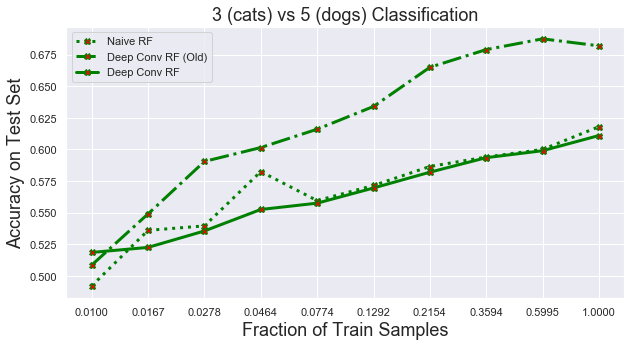

In [59]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()

plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams["legend.loc"] = "best"
plt.rcParams['figure.facecolor'] = 'white'

fig, ax = plt.subplots() # create a new figure with a default 111 subplot
ax.plot(fraction_of_train_samples_space, naive_rf_acc_vs_n, marker='X', markerfacecolor='red', markersize=6, color='green', linewidth=3, linestyle=":", label="Naive RF")
ax.plot(fraction_of_train_samples_space, deep_conv_rf_old_acc_vs_n, marker='X', markerfacecolor='red', markersize=6, color='green', linewidth=3, linestyle="-.", label="Deep Conv RF (Old)")
ax.plot(fraction_of_train_samples_space, deep_conv_rf_acc_vs_n, marker='X', markerfacecolor='red', markersize=6, color='green', linewidth=3, label="Deep Conv RF")

ax.set_xlabel('Fraction of Train Samples', fontsize=18)
ax.set_xscale('log')
ax.set_xticks(list(np.geomspace(0.01, 1.0, num=10)))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_ylabel('Accuracy on Test Set', fontsize=18)
# ax.set_ylim(0.85, 1)

ax.set_title("3 (cats) vs 5 (dogs) Classification", fontsize=18)
plt.legend()
plt.show()

In [24]:
# Define a simple CNN
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as utils

class SimpleCNN(torch.nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()        
        #Input channels = 1, output channels = 1
        self.conv1 = torch.nn.Conv2d(3, 1, kernel_size=10, stride=2) ## 32 or 64 filters
        self.fc1 = torch.nn.Linear(144*1, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 144*1)
        x = self.fc1(x)
        return(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:
print("Simple CNN Experiment (with one 10x10 filter, stride 2, one relu)")

# set params
num_epochs = 2
learning_rate = 0.001

# prepare data

# transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(np.concatenate([np.argwhere(cifar_train_labels==3).flatten(), np.argwhere(cifar_train_labels==5).flatten()]))
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, num_workers=2, sampler=train_sampler)

test_sampler = torch.utils.data.sampler.SubsetRandomSampler(np.concatenate([np.argwhere(cifar_test_labels==3).flatten(), np.argwhere(cifar_test_labels==5).flatten()]))
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2, sampler=test_sampler)
net = SimpleCNN()

########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         print(outputs.size(), labels.size())
#         labels[labels==3] = 0
#         labels[labels==5] = 1
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Simple CNN Experiment (with one 10x10 filter, stride 2, one relu)
Files already downloaded and verified
Files already downloaded and verified
[1,  2000] loss: 0.754
[2,  2000] loss: 0.694
Finished Training


In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
#         print(predicted.size())
#         print(labels.size())
        correct += (predicted == labels.view(-1)).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / float(total)))

Accuracy of the network on the 10000 test images: 58.000000 %


In [3]:
# compare to 1 layer CNN, using only 1 filter, and also using N (32 to 64) filters - Done

In [2]:
# fashion MNIST or SVHN or CIFAR or CatsVsDogs (FashionMNIST) - Two classes - Done

In [ ]:
# compare multiple layers for both convRF and CNN - Done

In [ ]:
# try SVHN or CIFAR or CatsVsDogs - CIFAR - Done

In [ ]:
# Compare with single and multi layer DeepConvRFs and CNN (with 1 and 32 trees/filters) CIFAR - Done

In [ ]:
# find optimal filter size configuration for the convRFs - Done

In [ ]:
# code: shared RF for all patches per layer
# chop images into patches and flatten them and then label them with a class, we have made MxM times more data now
# train a single massive RF with 1000 trees on all of this data

In [ ]:
# add plot: best possible for cnn on CIFAR

In [ ]:
# fashion MNIST or SVHN or CIFAR or CatsVsDogs (FashionMNIST) - N>2 classes

In [ ]:
# use richard's CEF posteriors

In [ ]:
# re run param sweep for 32, 100 trees (maybe)

In [ ]:
# Rerf Python

In [ ]:
# use homicide data (real data) ??

In [1]:
# sampling 10 times for DeepConvRF case and plot same curves for DeepConvRF.

In [2]:
# plot loss for all mini bathces and not just epochs in CNN

In [4]:
# capsule nets comparison